In [1]:
from IPython.display import Markdown, display, HTML
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import joblib
import gc
import warnings
from pathlib import Path
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Dictionary for the dataset
1. symbol = stock symbol
2. date = date of stock
3. open = opening price for the date
4. high = the highest price for the stock for that date
5. low = the lowest price for the stock for that date
6. close = the closing price for the stock for the date
7. volume = the volume of the particular stock bought for the day

In [2]:
# import data
stock_df = pd.read_csv('S&P 500 Stock Prices 2014-2017.csv')
stock_df.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


In [3]:
# make a copy
stk_cpy = stock_df.copy()

In [4]:
# extract the year, month and day from the date to know more about the data and drop the date column
stk_cpy['year'] = pd.to_datetime(stk_cpy['date']).dt.year
stk_cpy['month'] = pd.to_datetime(stk_cpy['date']).dt.month
stk_cpy['day'] = pd.to_datetime(stk_cpy['date']).dt.day
stk_cpy['day_name'] = pd.to_datetime(stk_cpy['date']).dt.day_name()

# drop date column
stk_cpy = stk_cpy.drop('date', axis=1)
stk_cpy.head()

,symbol,open,high,low,close,volume,year,month,day,day_name
0,AAL,25.0700,25.8200,25.0600,25.3600,8998943,2014,1,2,Thursday
1,AAPL,79.3828,79.5756,78.8601,79.0185,58791957,2014,1,2,Thursday
2,AAP,110.3600,111.8800,109.2900,109.7400,542711,2014,1,2,Thursday
3,ABBV,52.1200,52.3300,51.5200,51.9800,4569061,2014,1,2,Thursday
4,ABC,70.1100,70.2300,69.4800,69.8900,1148391,2014,1,2,Thursday


In [5]:
# check the year, month, day, day_name to check for any anomalies
print(f"Year: {stk_cpy['year'].unique()}")
print(f"\nDay Name: {stk_cpy['day_name'].unique()}")
print(f"\nMonth: {stk_cpy['month'].unique()}")
print(f"\nDay: {stk_cpy['day'].unique()}")

Year: [2014 2015 2016 2017]

Day Name: ['Thursday' 'Friday' 'Monday' 'Tuesday' 'Wednesday']

Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]

Day: [ 2  3  6  7  8  9 10 13 14 15 16 17 21 22 23 24 27 28 29 30 31  4  5 11
 12 18 19 20 25 26  1]


# there are two tasks to perform
1. to predict stock prices
2. to predict whether a price will go up and down

# what to do
1. to isolate one stock and build a prediction model around that
2. to separate the dataset from 2014 to 2016 and test the data on the 2017 data to see the accuracy of the model

In [6]:
# let's use the apple stock and divide into training and testing data
apple_stock = stk_cpy[(stk_cpy['symbol'] == 'AAPL')].reset_index(drop=True)
apple_stock.head()

,symbol,open,high,low,close,volume,year,month,day,day_name
0,AAPL,79.3828,79.5756,78.8601,79.0185,58791957,2014,1,2,Thursday
1,AAPL,78.9799,79.0999,77.2042,77.2828,98303870,2014,1,3,Friday
2,AAPL,76.7785,78.1142,76.2285,77.7042,103359151,2014,1,6,Monday
3,AAPL,77.7599,77.9942,76.8464,77.1481,79432766,2014,1,7,Tuesday
4,AAPL,76.9728,77.9371,76.9556,77.6371,64686685,2014,1,8,Wednesday


In [7]:
# perform the eda on the apple stock
def perform_eda(data, target_column=None, num_bins=20):
    """
    Performs exploratory data analysis (EDA) on a dataset.

    Args:
        data (pd.DataFrame): The dataset to analyze.
        target_column (str, optional): Name of the target column for analysis. Defaults to None.
        num_bins (int, optional): Number of bins for histograms. Defaults to 20.

    Returns:
        None: Displays EDA results including statistics, distributions, and visualizations.
    """
    print("===== EDA Summary =====\n")
    
    # 1. Basic Information
    print("1. Basic Information:")
    print(f"Shape of dataset: {data.shape}")
    print("\nData Types:\n", data.dtypes)
    print("\nSample Data:\n", data.head(), "\n")

    # 2. Check for Missing Values
    print("2. Missing Values:")
    missing_values = data.isnull().sum()
    if missing_values.any():
        print(missing_values[missing_values > 0], "\n")
    else:
        print("No missing values detected.\n")
    
    # 3. Summary Statistics
    print("3. Summary Statistics:")
    print(data.describe(include='all'), "\n")

    # 4. Target Column Analysis
    if target_column and target_column in data.columns:
        print(f"4. Target Column Analysis: {target_column}")
        if data[target_column].dtype == 'object':
            # If the target column is categorical
            print("\nValue Counts:\n", data[target_column].value_counts(), "\n")
            try:
                plt.figure(figsize=(8, 4))
                sns.countplot(y=target_column, data=data, order=data[target_column].value_counts().index)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()  # Adjust layout to prevent overlap
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
        elif data[target_column].dtype in ['int64', 'float64']:
            # If the target column is numeric (int64 or float64)
            try:
                sns.histplot(data[target_column], kde=True, bins=num_bins)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
    else:
        print("No target column specified or invalid target column.")

    # 5. Visualizations for Numeric Features
    print("5. Numeric Feature Distributions:")
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        try:
            data[numeric_columns].hist(figsize=(12, 8), bins=num_bins)
            plt.suptitle("Numeric Feature Distributions", fontsize=16)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting numeric distributions: {e}")
    else:
        print("No numeric column found to plot")

    # 6. Correlation Heatmap
    print("6. Correlation Analysis:")
    if len(numeric_columns) > 0:
        try:
            correlation_matrix = data[numeric_columns].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting heatmap: {e}")
    else:
        print("No numeric column found to perform correlation")

    # 7. Categorical Feature Analysis
    print("7. Categorical Features:")
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_columns) > 0:
        for column in categorical_columns:
            try:
                print(f"\nValue Counts for {column}:\n", data[column].value_counts())
                plt.figure(figsize=(8, 4))
                sns.countplot(y=column, data=data, order=data[column].value_counts().index)
                plt.title(f"Distribution of {column}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting {column}: {e}")
    else:
        print("No categorical features found.")

    print("\n===== EDA Complete =====")


===== EDA Summary =====

1. Basic Information:
Shape of dataset: (1007, 10)

Data Types:
 symbol       object
open        float64
high        float64
low         float64
close       float64
volume        int64
year          int32
month         int32
day           int32
day_name     object
dtype: object

Sample Data:
   symbol     open     high      low    close     volume  year  month  day  \
0   AAPL  79.3828  79.5756  78.8601  79.0185   58791957  2014      1    2   
1   AAPL  78.9799  79.0999  77.2042  77.2828   98303870  2014      1    3   
2   AAPL  76.7785  78.1142  76.2285  77.7042  103359151  2014      1    6   
3   AAPL  77.7599  77.9942  76.8464  77.1481   79432766  2014      1    7   
4   AAPL  76.9728  77.9371  76.9556  77.6371   64686685  2014      1    8   

    day_name  
0   Thursday  
1     Friday  
2     Monday  
3    Tuesday  
4  Wednesday   

2. Missing Values:
No missing values detected.

3. Summary Statistics:
       symbol         open         high          low   

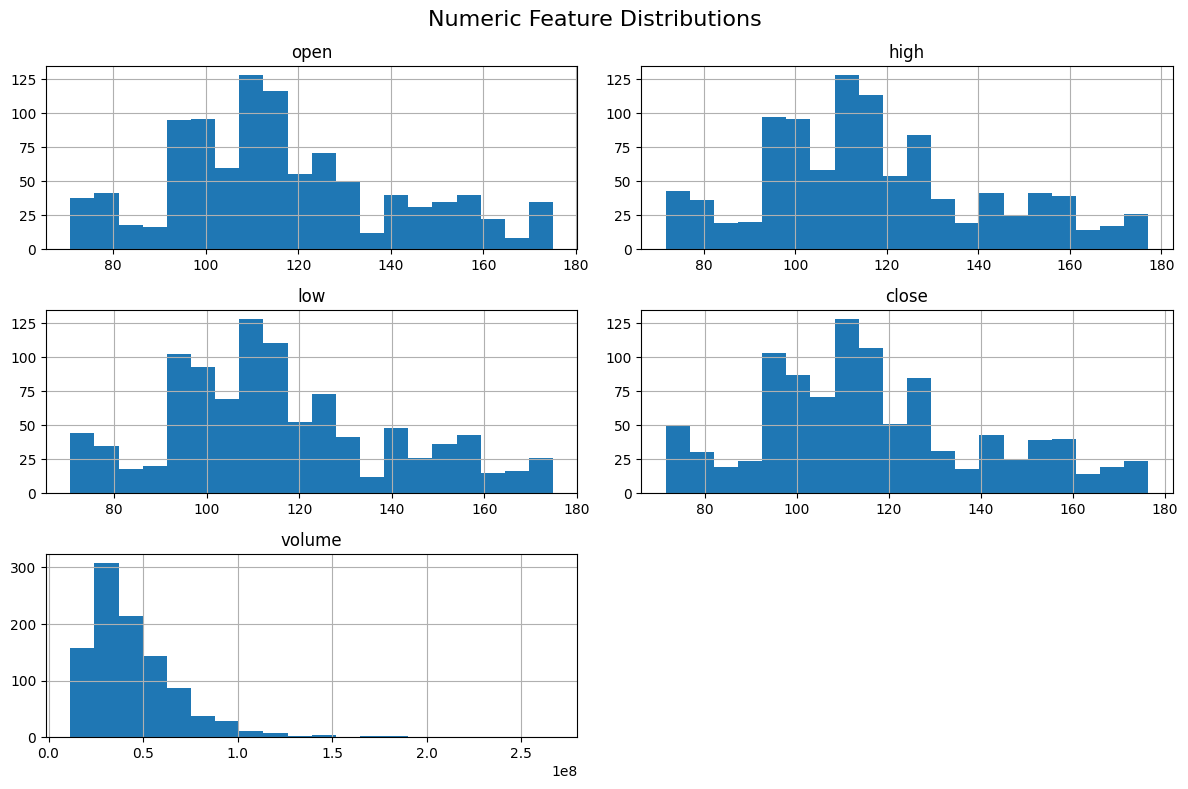

6. Correlation Analysis:


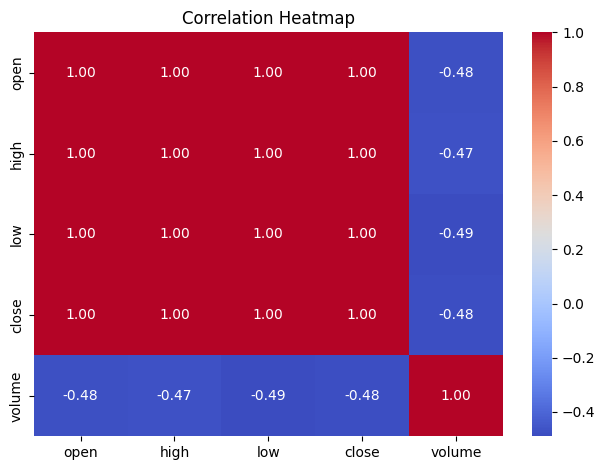

7. Categorical Features:

Value Counts for symbol:
 symbol
AAPL    1007
Name: count, dtype: int64


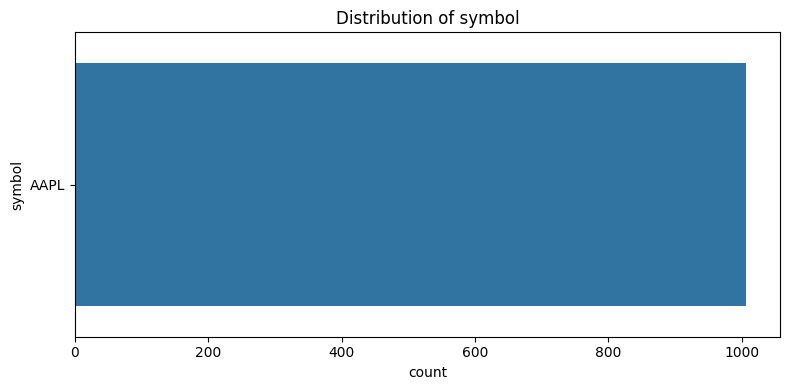


Value Counts for day_name:
 day_name
Wednesday    208
Tuesday      207
Thursday     203
Friday       201
Monday       188
Name: count, dtype: int64


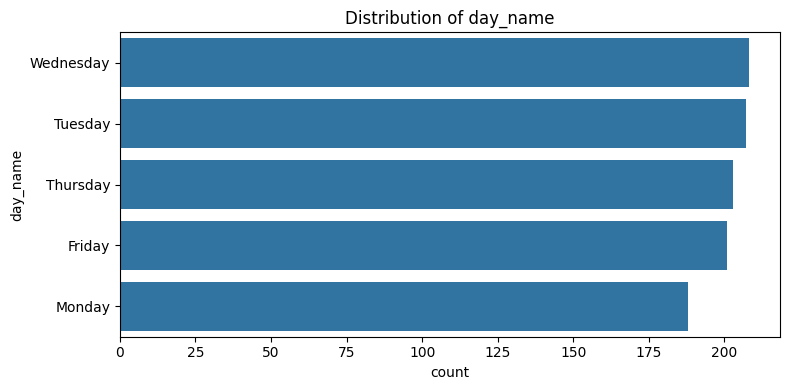


===== EDA Complete =====


In [8]:
perform_eda(apple_stock)

In [9]:
# split the data into training and testing sets
apple_d1 = apple_stock[(apple_stock['year'] >= 2014) & (apple_stock['year'] <= 2016)]
apple_d2 = apple_stock[apple_stock['year'] == 2017]

In [10]:
apple_d1.shape

(756, 10)

In [11]:
apple_d2.shape

(251, 10)

# TASK 1 -- predicting apple stock prices

In [12]:
# divide the data
X1 = apple_d1.drop(['close','symbol'], axis=1)
y1 = apple_d1['close']

# same for testing data
X2 = apple_d2.drop(['close','symbol'], axis=1)
y2 = apple_d2['close']

In [13]:
# Encode 'day_name' column
day_name_encoder = LabelEncoder()
X1['day_name_encoded'] = day_name_encoder.fit_transform(X1['day_name'])
X2['day_name_encoded'] = day_name_encoder.transform(X2['day_name'])

# Drop redundant columns
X1 = X1.drop('day_name', axis=1)
X2 = X2.drop('day_name', axis=1)


In [14]:
# scale the data
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.transform(X2)

In [15]:
# Train and Test Split for Time Series (Train: 2014-2016, Test: 2017)
X_train = X1_scaled
y_train = y1
X_test = X2_scaled
y_test = y2

In [16]:
# Initialize models
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, use_label_encoder=False, eval_metric="rmse")
lr = LinearRegression()
gb = GradientBoostingRegressor(random_state=42)

In [17]:
# Train and evaluate RandomForestRegressor
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Evaluate RandomForestRegressor
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f"RandomForestRegressor on 2017 - Mean Squared Error: {rf_mse}")
print(f"RandomForestRegressor on 2017 - R-squared: {rf_r2}")

RandomForestRegressor on 2017 - Mean Squared Error: 549.4701904789332
RandomForestRegressor on 2017 - R-squared: -1.577452644533822


In [18]:
# Train and evaluate XGBRegressor
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# Evaluate XGBRegressor
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)
print(f"XGBRegressor on 2017 - Mean Squared Error: {xgb_mse}")
print(f"XGBRegressor on 2017 - R-squared: {xgb_r2}")

XGBRegressor on 2017 - Mean Squared Error: 564.3507550768741
XGBRegressor on 2017 - R-squared: -1.647254339402271


C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
# Linear Regression Model

lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

# Evaluate Linear Regression
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)
print(f"Linear Regression on 2017 - Mean Squared Error: {lr_mse}")
print(f"Linear Regression on 2017 - R-squared: {lr_r2}")

Linear Regression on 2017 - Mean Squared Error: 0.27088982752063584
Linear Regression on 2017 - R-squared: 0.9987293110446778


In [20]:
# Gradient Boosting Model

gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

# Evaluate Gradient Boosting
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)
print(f"Gradient Boosting on 2017 - Mean Squared Error: {gb_mse}")
print(f"Gradient Boosting on 2017 - R-squared: {gb_r2}")

Gradient Boosting on 2017 - Mean Squared Error: 542.2531392020625
Gradient Boosting on 2017 - R-squared: -1.5435989283147618


# NOTES
1. the linear model performed better. this is largely due to the fact that the data shows a linear relationship.
2. the other complex models performed very poorly.

In [21]:
# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': lr_y_pred
})

# Display the comparison
print(comparison_df.tail(50))

      Actual   Predicted
957   155.98  155.602201
958   156.25  157.001173
959   156.17  156.410332
960   157.10  157.125861
961   156.41  156.104369
962   157.41  157.339201
963   163.05  162.253800
964   166.72  167.077009
965   169.04  168.496576
966   166.89  166.556899
967   168.11  166.466402
968   172.50  171.888424
969   174.25  173.989613
970   174.81  174.776269
971   176.24  175.705102
972   175.88  174.345671
973   174.67  174.664227
974   173.97  174.244067
975   171.34  171.914559
976   169.08  168.980350
977   171.10  171.033102
978   170.15  170.195002
979   169.98  169.917053
980   173.14  173.133523
981   174.96  174.424950
982   174.97  175.041084
983   174.09  173.671167
984   173.07  172.771336
985   169.48  168.431140
986   171.85  170.156162
987   171.05  170.194339
988   169.80  170.326236
989   169.64  170.551188
990   169.01  168.884571
991   169.32  170.092641
992   169.37  169.577550
993   172.67  171.854544
994   171.70  171.803978
995   172.27  172.948497


# the linear regression model performed very good. I will move on to predict the direction of stocks and its rate. I will still use the same apple stock.

# TASK 2

In [22]:
# this code calculates the rate of change in 'close' column over a 2 day period
apple_stock["Close_shift1"] = apple_stock["close"].shift(-1)
apple_stock["Close_shift2"] = apple_stock["close"].shift(-2)

apple_stock["rate"] = (apple_stock["Close_shift2"] - apple_stock["Close_shift1"]) / apple_stock["Close_shift1"]
apple_stock.head()

,symbol,open,high,low,close,volume,year,month,day,day_name,Close_shift1,Close_shift2,rate
0,AAPL,79.3828,79.5756,78.8601,79.0185,58791957,2014,1,2,Thursday,77.2828,77.7042,0.005453
1,AAPL,78.9799,79.0999,77.2042,77.2828,98303870,2014,1,3,Friday,77.7042,77.1481,-0.007157
2,AAPL,76.7785,78.1142,76.2285,77.7042,103359151,2014,1,6,Monday,77.1481,77.6371,0.006338
3,AAPL,77.7599,77.9942,76.8464,77.1481,79432766,2014,1,7,Tuesday,77.6371,76.6455,-0.012772
4,AAPL,76.9728,77.9371,76.9556,77.6371,64686685,2014,1,8,Wednesday,76.6455,76.1342,-0.006671


In [23]:
# Calculate the consecutive differences in the 'close' column
apple_stock["Close_diff"] = apple_stock["close"].diff()

# Calculate the change in direction
apple_stock["Direction"] = apple_stock["Close_diff"].apply(lambda x: "Up" if x > 0 else ("Down" if x < 0 else "No Change"))

# Display the first few rows
apple_stock.head()

,symbol,open,high,low,close,volume,year,month,day,day_name,Close_shift1,Close_shift2,rate,Close_diff,Direction
0,AAPL,79.3828,79.5756,78.8601,79.0185,58791957,2014,1,2,Thursday,77.2828,77.7042,0.005453,NaN,No Change
1,AAPL,78.9799,79.0999,77.2042,77.2828,98303870,2014,1,3,Friday,77.7042,77.1481,-0.007157,-1.7357,Down
2,AAPL,76.7785,78.1142,76.2285,77.7042,103359151,2014,1,6,Monday,77.1481,77.6371,0.006338,0.4214,Up
3,AAPL,77.7599,77.9942,76.8464,77.1481,79432766,2014,1,7,Tuesday,77.6371,76.6455,-0.012772,-0.5561,Down
4,AAPL,76.9728,77.9371,76.9556,77.6371,64686685,2014,1,8,Wednesday,76.6455,76.1342,-0.006671,0.4890,Up


In [24]:
# drop some columns for now
apple_stock = apple_stock.drop(['symbol', 'Close_shift1', 'Close_shift2','Close_diff'], axis=1)

In [25]:
apple_stock.head()

,open,high,low,close,volume,year,month,day,day_name,rate,Direction
0,79.3828,79.5756,78.8601,79.0185,58791957,2014,1,2,Thursday,0.005453,No Change
1,78.9799,79.0999,77.2042,77.2828,98303870,2014,1,3,Friday,-0.007157,Down
2,76.7785,78.1142,76.2285,77.7042,103359151,2014,1,6,Monday,0.006338,Up
3,77.7599,77.9942,76.8464,77.1481,79432766,2014,1,7,Tuesday,-0.012772,Down
4,76.9728,77.9371,76.9556,77.6371,64686685,2014,1,8,Wednesday,-0.006671,Up


In [26]:
# Initialize the LabelEncoder
label = LabelEncoder()

# Apply the label encoder to 'day_name' and 'Direction' separately
apple_stock['day_name_encoded'] = label.fit_transform(apple_stock['day_name'])
apple_stock['direction_encoded'] = label.fit_transform(apple_stock['Direction'])

# Drop the original columns if they are no longer needed
apple_stock = apple_stock.drop(['day_name', 'Direction'], axis=1)

# Display the first few rows to check
print(apple_stock.head())


      open     high      low    close     volume  year  month  day      rate  \
0  79.3828  79.5756  78.8601  79.0185   58791957  2014      1    2  0.005453   
1  78.9799  79.0999  77.2042  77.2828   98303870  2014      1    3 -0.007157   
2  76.7785  78.1142  76.2285  77.7042  103359151  2014      1    6  0.006338   
3  77.7599  77.9942  76.8464  77.1481   79432766  2014      1    7 -0.012772   
4  76.9728  77.9371  76.9556  77.6371   64686685  2014      1    8 -0.006671   

   day_name_encoded  direction_encoded  
0                 2                  1  
1                 0                  0  
2                 1                  2  
3                 3                  0  
4                 4                  2  


In [27]:
# divide into variables
X = apple_stock.drop('direction_encoded', axis=1)
y = apple_stock['direction_encoded']

In [30]:
# check for null values
X.isnull().sum()

open                0
high                0
low                 0
close               0
volume              0
year                0
month               0
day                 0
rate                0
day_name_encoded    0
dtype: int64

In [29]:
# impute the missing values with the mean using the sklearn.impute
# Create an imputer that will fill missing values with the mean of rate column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the DataFrame
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# Display the DataFrame after imputation
print(X.tail())

        open     high      low   close      volume    year  month   day  \
1002  174.68  175.424  174.500  175.01  16349444.0  2017.0   12.0  22.0   
1003  170.80  171.470  169.679  170.57  33185536.0  2017.0   12.0  26.0   
1004  170.10  170.780  169.710  170.60  21498213.0  2017.0   12.0  27.0   
1005  171.00  171.850  170.480  171.08  16480187.0  2017.0   12.0  28.0   
1006  170.52  170.590  169.220  169.23  25999922.0  2017.0   12.0  29.0   

          rate  day_name_encoded  
1002  0.000176               0.0  
1003  0.002814               3.0  
1004 -0.010814               4.0  
1005  0.000882               2.0  
1006  0.000882               0.0  


In [31]:
# scale the data
scale = MinMaxScaler()
X_ = scale.fit_transform(X)

In [32]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

NameError: name 'X_scaled' is not defined

In [19]:
# Initialize and train a random classifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
# One-vs-Rest ROC-AUC score (if applicable)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')

print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

ROC-AUC Score: 0.5457959703235363
Accuracy: 0.5765765765765766
Confusion Matrix:
[[ 80   0  88]
 [  0   0   1]
 [ 52   0 112]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.48      0.53       168
           1       0.00      0.00      0.00         1
           2       0.56      0.68      0.61       164

    accuracy                           0.58       333
   macro avg       0.39      0.39      0.38       333
weighted avg       0.58      0.58      0.57       333



C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [20]:
# using the xg boost
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# One-vs-Rest ROC-AUC score (if applicable)
roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc}")

print(f"accuracy is: {accuracy}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)

C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC-AUC Score: 0.6249345212923729
accuracy is: 0.6186186186186187
              precision    recall  f1-score   support

           0       0.66      0.51      0.57       168
           1       0.00      0.00      0.00         1
           2       0.59      0.74      0.66       164

    accuracy                           0.62       333
   macro avg       0.42      0.41      0.41       333
weighted avg       0.63      0.62      0.61       333

Confusion Matrix:
[[ 85   0  83]
 [  0   0   1]
 [ 43   0 121]]


C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [21]:
# using logistic regression
# Initialize and train logistic regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# ROUGH WORK

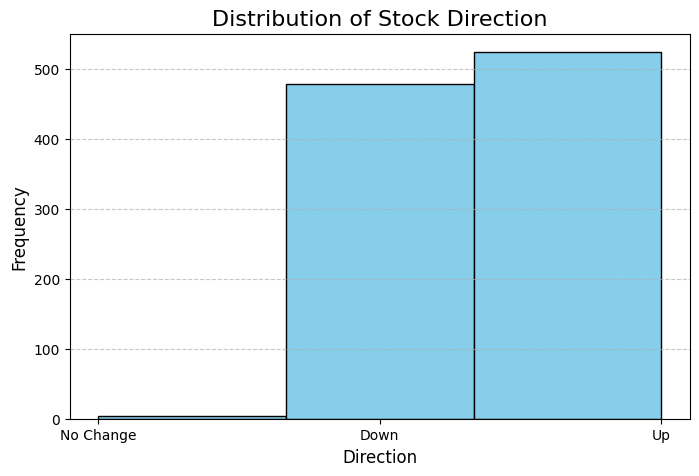

In [36]:
# plot the 'direction' column
plt.figure(figsize=(8, 5))
plt.hist(apple_stock['Direction'], bins=3, edgecolor='black', color='skyblue')
plt.title('Distribution of Stock Direction', fontsize=16)
plt.xlabel('Direction', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


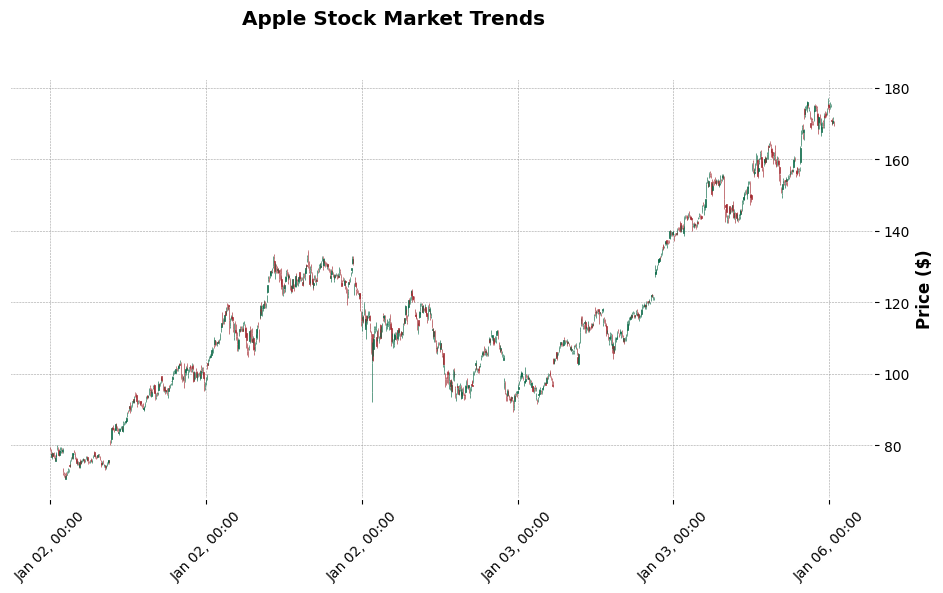

In [48]:
import pandas as pd
import mplfinance as mpf

# Ensure 'date' column is in datetime format
apple_stock['date'] = pd.to_datetime(apple_stock['date'])

# Prepare data for candlestick chart
# Ensure columns like 'open', 'high', 'low', and 'close' are present in the DataFrame
ohlc_data = apple_stock[['date', 'open', 'high', 'low', 'close']].set_index('date')

# Plot candlestick chart
mpf.plot(
    ohlc_data,
    type='candle',
    style='charles',
    title='Apple Stock Market Trends',
    ylabel='Price ($)',
    volume=False,
    figsize=(12, 6)
)


In [30]:
#This is a function that downcast the integer columns
def downcast_df_int_columns(df):
    list_of_columns = list(df.select_dtypes(include=["int32", "int64"]).columns)
        
    if len(list_of_columns)>=1:
        max_string_length = max([len(col) for col in list_of_columns]) # finds max string length for better status printing
        print("downcasting integers for:", list_of_columns, "\n")
        
        for col in list_of_columns:
            print("reduced memory usage for:  ", col.ljust(max_string_length+2)[:max_string_length+2],
                  "from", str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8), "to", end=" ")
            df[col] = pd.to_numeric(df[col], downcast="integer")
            print(str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8))
    else:
        print("no columns to downcast")
    
    gc.collect()
    
    print("done")
    
    
#This is a function that downcast the float columns,
#if you have too many columns to adjust and do not want to see to many messages proceesing, you could comment our the print() columns
def downcast_df_float_columns(df):
    list_of_columns = list(df.select_dtypes(include=["float64"]).columns)
        
    if len(list_of_columns)>=1:
        max_string_length = max([len(col) for col in list_of_columns]) # finds max string length for better status printing
        print("downcasting float for:", list_of_columns, "\n")
        
        for col in list_of_columns:
            print("reduced memory usage for:  ", col.ljust(max_string_length+2)[:max_string_length+2],
                  "from", str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8), "to", end=" ")
            df[col] = pd.to_numeric(df[col], downcast="float")
            print(str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8))
    else:
        print("no columns to downcast")
    
    gc.collect()
    print("done")
    

warnings.filterwarnings("ignore")

In [31]:
print(' \n\t\t\t\t\t\t\tReducing the size of integer columns by converting them from int64 to int32\n\n\n')
downcast_df_int_columns(apple_stock)

 
							Reducing the size of integer columns by converting them from int64 to int32



downcasting integers for: ['volume', 'year', 'month', 'day'] 

reduced memory usage for:   volume   from     0.01 to      0.0
reduced memory usage for:   year     from      0.0 to      0.0
reduced memory usage for:   month    from      0.0 to      0.0
reduced memory usage for:   day      from      0.0 to      0.0
done
